In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score

NUM_CLASSES = 12
RESULTS_BASE_DIR = "C:/Users/Ivica Obadic/EO_explainability_survey/training_results/bavarian_crops/{}_classes/".format(NUM_CLASSES)

def read_classification_data_file(classification_results_dir):
    classification_results_path = os.path.join(classification_results_dir, "predictions", "classification_metrics.csv")
    classification_data = np.genfromtxt(classification_results_path, delimiter=',', skip_header = 1)
    return classification_data

def aggregate_sampling_results(sampling_results_dirs, sampling_type):
    results = []
    for sampling_result_dir in sampling_results_dirs:
        
        classification_data = read_classification_data_file(sampling_result_dir)
        classification_data = np.reshape(classification_data, (1, classification_data.shape[0]))
        results.append(classification_data.tolist())
    
    results = np.array(results).mean(axis=0)
    return [sampling_type, results[0, 1], results[0, 3], results[0, -1]]

def get_classification_data(experiment_directory):
    if experiment_directory != "sampling":
        classification_results = read_classification_data_file(os.path.join(RESULTS_BASE_DIR, experiment_directory))
        result_list = [(experiment_directory,
                 classification_results[1],
                 classification_results[3],
                 classification_results[-1])]
    else:
        result_list = []
        sampling_results_dir = os.path.join(RESULTS_BASE_DIR, experiment_directory)

        fixed_sampling_result_dirs = [os.path.join(sampling_results_dir, o) for o in os.listdir(sampling_results_dir) 
                                      if o.split("_")[0] == "fixed"]
        random_sampling_result_dirs = [os.path.join(sampling_results_dir, o) for o in os.listdir(sampling_results_dir) 
                                       if o.split("_")[0] == "random"]
                        
        result_list.append(aggregate_sampling_results(fixed_sampling_result_dirs, "fixed_sampling"))
        result_list.append(aggregate_sampling_results(random_sampling_result_dirs, "random_sampling"))
    
    return result_list

def get_parcel_region_mapping(
    root_parcel_mapping_dir = "C:/Users/Ivica Obadic/Desktop/Explainable Machine Learning in Earth Observations/Projects/EO_explainability_survey/Datasets/BavarianCrops/ids/blocks"):
    parcel_region_mapping = []
    parcel_mapping_files = [("holl", os.path.join(root_parcel_mapping_dir, "holl_test.txt")),
                            ("nowa", os.path.join(root_parcel_mapping_dir, "nowa_test.txt")),
                            ("krum", os.path.join(root_parcel_mapping_dir, "krum_test.txt"))]
    
    for region, parcel_mapping_file in parcel_mapping_files:
            with open(parcel_mapping_file, 'r') as parcel_mapping:
                parcels_for_region = [(region, int(parcel_id.strip())) for parcel_id in parcel_mapping.readlines()]
                parcel_region_mapping.extend(parcels_for_region)
    
    parcel_region_mapping_df = pd.DataFrame(parcel_region_mapping, columns = ["REGION", "PARCEL_ID"])
    return parcel_region_mapping_df

def calc_accuracy_stats_region_wise(parcel_region_mapping, model_root_path, aggregation_method):
    
    def calc_accuracy_per_region(df_region):
        accuracy = accuracy_score(df_region["LABEL"], df_region["PREDICTION"])
        f1 = f1_score(df_region["LABEL"], df_region["PREDICTION"], average="macro", zero_division=0)
        kappa = cohen_kappa_score(df_region["LABEL"], df_region["PREDICTION"])
        return pd.Series({'F1 SCORE': f1, 'AGGREGATION_METHOD': aggregation_method})
        #return pd.Series({'ACCURACY': accuracy, 'F1_SCORE': f1, 'KAPPA_SCORE': kappa, 'MODEL': aggregation_method})
        
    
    predictions_file = os.path.join(model_root_path, aggregation_method, "predictions", "predicted_vs_true.csv")
    predictions = pd.read_csv(predictions_file)
    predictions_with_region = pd.merge(parcel_region_mapping, predictions, on="PARCEL_ID")
    predictions_with_region = predictions_with_region.groupby("REGION").apply(calc_accuracy_per_region).reset_index()
    #predictions_with_region = pd.melt(predictions_with_region, id_vars = ["REGION", "MODEL"], value_vars = ["ACCURACY", "F1_SCORE", "KAPPA_SCORE"])
    #predictions_with_region.rename(columns = {"variable": "Classification Metric", "value": "Value"}, inplace=True)
    return predictions_with_region

In [16]:
RESULTS_BASE_DIR = "C:/Users/Ivica Obadic/EO_explainability_survey/training_results/bavarian_crops/pos_enc_obs_date/{}_classes/".format(NUM_CLASSES)
experiments_root_directories = [o for o in os.listdir(RESULTS_BASE_DIR) 
                               if os.path.isdir(os.path.join(RESULTS_BASE_DIR,o))]


results_pe_obs_date = []
for i, experiment_directory in enumerate(experiments_root_directories):
    results_pe_obs_date.extend(get_classification_data(experiment_directory))
    
results_pe_obs_date = pd.DataFrame(results_pe_obs_date, columns = ["AGGREGATION_METHOD", "ACCURACY", "KAPPA_SCORE", "F1_SCORE"])
results_pe_obs_date = results_pe_obs_date.melt(id_vars='AGGREGATION_METHOD').rename(columns=str.title)
results_pe_obs_date.rename(columns = {"Variable": "Classification Metric"}, inplace=True)
results_pe_obs_date["POSITIONAL_ENCODING"] = "OBS_ACQUISITION_DATE"

In [18]:
RESULTS_BASE_DIR = "C:/Users/Ivica Obadic/EO_explainability_survey/training_results/bavarian_crops/pos_enc_pos/{}_classes/".format(NUM_CLASSES)
experiments_root_directories = [o for o in os.listdir(RESULTS_BASE_DIR) 
                               if os.path.isdir(os.path.join(RESULTS_BASE_DIR,o))]


results = []
for i, experiment_directory in enumerate(experiments_root_directories):
    results.extend(get_classification_data(experiment_directory))
    
results = pd.DataFrame(results, columns = ["AGGREGATION_METHOD", "ACCURACY", "KAPPA_SCORE", "F1_SCORE"])
results = results.melt(id_vars='AGGREGATION_METHOD').rename(columns=str.title)
results.rename(columns = {"Variable": "Classification Metric"}, inplace=True)
results["POSITIONAL_ENCODING"] = "FIXED_POSITION" 
print(results)

   Aggregation_Method Classification Metric     Value POSITIONAL_ENCODING
0       right_padding              ACCURACY  0.860581      FIXED_POSITION
1      fixed_sampling              ACCURACY  0.908243      FIXED_POSITION
2     random_sampling              ACCURACY  0.912178      FIXED_POSITION
3      weekly_average              ACCURACY  0.898035      FIXED_POSITION
4       right_padding           KAPPA_SCORE  0.768350      FIXED_POSITION
5      fixed_sampling           KAPPA_SCORE  0.841702      FIXED_POSITION
6     random_sampling           KAPPA_SCORE  0.848554      FIXED_POSITION
7      weekly_average           KAPPA_SCORE  0.824745      FIXED_POSITION
8       right_padding              F1_SCORE  0.635324      FIXED_POSITION
9      fixed_sampling              F1_SCORE  0.660653      FIXED_POSITION
10    random_sampling              F1_SCORE  0.671243      FIXED_POSITION
11     weekly_average              F1_SCORE  0.604444      FIXED_POSITION


   Aggregation_Method Classification Metric     Value   POSITIONAL_ENCODING
4       right_padding           KAPPA_SCORE  0.778014  OBS_ACQUISITION_DATE
5      fixed_sampling           KAPPA_SCORE  0.772737  OBS_ACQUISITION_DATE
6     random_sampling           KAPPA_SCORE  0.856664  OBS_ACQUISITION_DATE
7      weekly_average           KAPPA_SCORE  0.831256  OBS_ACQUISITION_DATE
16      right_padding           KAPPA_SCORE  0.768350        FIXED_POSITION
17     fixed_sampling           KAPPA_SCORE  0.841702        FIXED_POSITION
18    random_sampling           KAPPA_SCORE  0.848554        FIXED_POSITION
19     weekly_average           KAPPA_SCORE  0.824745        FIXED_POSITION
   Aggregation_Method Classification Metric     Value   POSITIONAL_ENCODING
8       right_padding              F1_SCORE  0.685346  OBS_ACQUISITION_DATE
9      fixed_sampling              F1_SCORE  0.655292  OBS_ACQUISITION_DATE
10    random_sampling              F1_SCORE  0.687094  OBS_ACQUISITION_DATE
11     weekl

Text(0.5, 0.98, 'Comparison of Classification Scores')

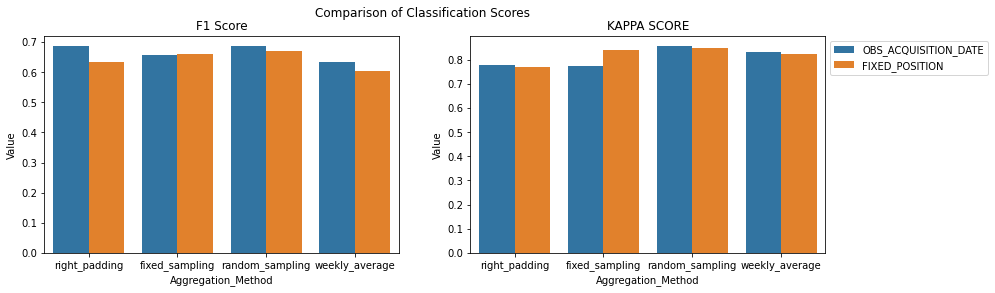

In [24]:
all_results = pd.concat([results_pe_obs_date, results], ignore_index=True, sort=False)

all_results_accuracy = all_results[all_results["Classification Metric"] == "KAPPA_SCORE"]
print(all_results_accuracy)

all_results_f1 = all_results[all_results["Classification Metric"] == "F1_SCORE"]
print(all_results_f1)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
barplot = sns.barplot(x="Aggregation_Method", y="Value", hue="POSITIONAL_ENCODING", data=all_results_f1, ax = axs[0])
axs[0].get_legend().remove()
barplot.set_title("F1 Score")

barplot = sns.barplot(x="Aggregation_Method", y="Value", hue="POSITIONAL_ENCODING", data=all_results_accuracy, ax = axs[1])
barplot.legend(loc='upper left', bbox_to_anchor=(1, 1))
barplot.set_title("KAPPA SCORE")

fig.suptitle("Comparison of Classification Scores", fontsize=12)

In [9]:
parcel_region_mapping = get_parcel_region_mapping()
model_root_path = "C:/Users/Ivica Obadic/EO_explainability_survey/training_results/bavarian_crops/pos_enc_obs_date/{}_classes/".format(NUM_CLASSES)
aggregation_method = "weekly_average"

results_average = calc_accuracy_stats_region_wise(parcel_region_mapping, model_root_path, aggregation_method)
aggregation_method = "right_padding"
results_padding = calc_accuracy_stats_region_wise(parcel_region_mapping, model_root_path, aggregation_method)

aggregation_method = "sampling/random_70_obs_1626951924"
results_random_sampling = calc_accuracy_stats_region_wise(parcel_region_mapping, model_root_path, aggregation_method)

results_random_sampling["AGGREGATION_METHOD"].replace({"sampling/random_70_obs_1626951924": "random_sampling"}, inplace=True)

results_pos_enc = pd.concat([results_average, results_padding, results_random_sampling], ignore_index=True, sort=False)
results_pos_enc

,REGION,F1 SCORE,AGGREGATION_METHOD
0,holl,0.612288,weekly_average
1,krum,0.667060,weekly_average
2,nowa,0.567033,weekly_average
3,holl,0.701248,right_padding
4,krum,0.786891,right_padding
5,nowa,0.454549,right_padding
6,holl,0.669351,random_sampling
7,krum,0.747690,random_sampling
8,nowa,0.628360,random_sampling


In [10]:
parcel_region_mapping = get_parcel_region_mapping()
model_root_path = "C:/Users/Ivica Obadic/EO_explainability_survey/training_results/bavarian_crops/pos_enc_pos/{}_classes/".format(NUM_CLASSES)
aggregation_method = "weekly_average"

results_average = calc_accuracy_stats_region_wise(parcel_region_mapping, model_root_path, aggregation_method)
aggregation_method = "right_padding"
results_padding = calc_accuracy_stats_region_wise(parcel_region_mapping, model_root_path, aggregation_method)

aggregation_method = "sampling/random_70_obs_1623094152.1401613"
results_random_sampling = calc_accuracy_stats_region_wise(parcel_region_mapping, model_root_path, aggregation_method)

results_random_sampling["AGGREGATION_METHOD"].replace({"sampling/random_70_obs_1623094152.1401613": "random_sampling"}, inplace=True)

results_pos_enc_pos = pd.concat([results_average, results_padding, results_random_sampling], ignore_index=True, sort=False)
results_pos_enc_pos

,REGION,F1 SCORE,AGGREGATION_METHOD
0,holl,0.565870,weekly_average
1,krum,0.660441,weekly_average
2,nowa,0.521981,weekly_average
3,holl,0.659517,right_padding
4,krum,0.692671,right_padding
5,nowa,0.418754,right_padding
6,holl,0.652016,random_sampling
7,krum,0.710056,random_sampling
8,nowa,0.575372,random_sampling


Text(0.5, 1.0, 'Classification by Region - Fixed Positional Encoding')

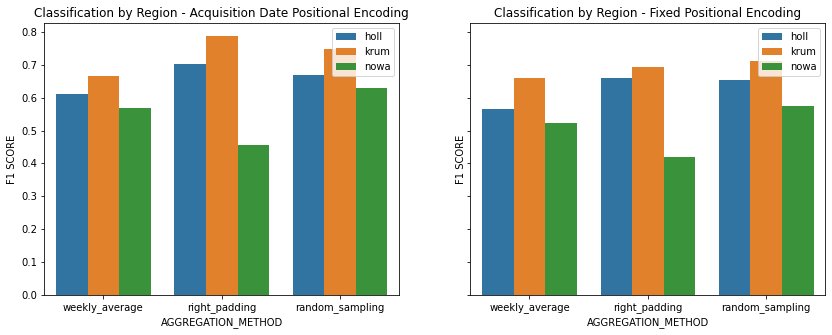

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), sharey=True)
barplot = sns.barplot(x="AGGREGATION_METHOD", y="F1 SCORE", hue="REGION", data=results_pos_enc, ax = axs[0])
barplot.legend(loc='upper right', bbox_to_anchor=(1, 1))
barplot.set_title("Classification by Region - Acquisition Date Positional Encoding")

barplot = sns.barplot(x="AGGREGATION_METHOD", y="F1 SCORE", hue="REGION", data=results_pos_enc_pos, ax = axs[1])
barplot.legend(loc='upper right', bbox_to_anchor=(1, 1))
barplot.set_title("Classification by Region - Fixed Positional Encoding")